# Viet, DT

In [24]:
from perform_kickstarer_eda import *

In [25]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd

10 features: R² = 0.4754
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'launch_to_deadline_days', 'blurb_len_clean', 'created_at_day', 'created_at_hr', 'create_to_launch_days', 'launched_at_day', 'name_len_clean']
20 features: R² = 0.4789
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'launch_to_deadline_days', 'blurb_len_clean', 'created_at_day', 'created_at_hr', 'create_to_launch_days', 'launched_at_day', 'name_len_clean', 'launched_at_hr', 'deadline_day', 'state_changed_at_day', 'created_at_month', 'state_changed_at_hr', 'state_changed_at_month', 'category_Software', 'launched_at_month', 'category_Gadgets', 'deadline_month']
30 features: R² = 0.4804
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'launch_to_deadline_days', 'blurb_len_clean', 'created_at_day', 'created_at_hr', 'create_to_launch_days', 'launched_at_day', 'name_len_clean', 'launched_at_hr', 'deadline_day', 'state_changed_at_day', 'cr

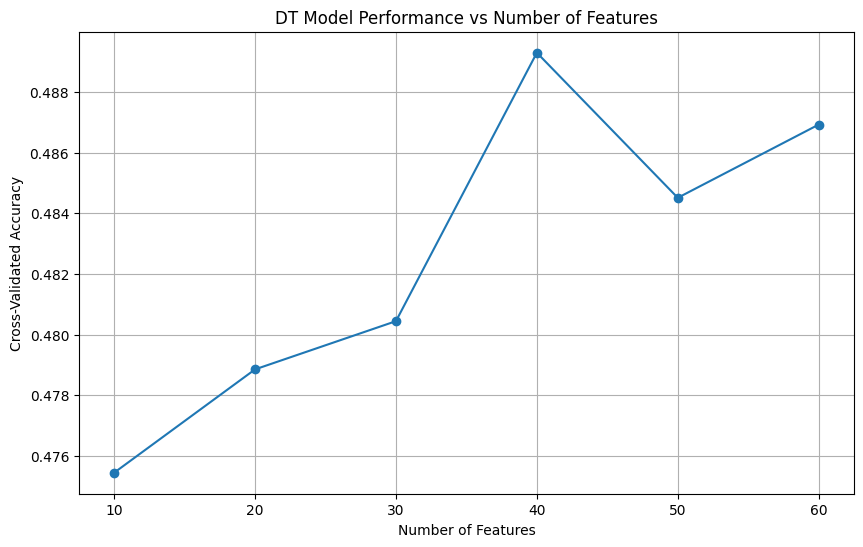


Optimal number of features: 40
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'launch_to_deadline_days', 'blurb_len_clean', 'created_at_day', 'created_at_hr', 'create_to_launch_days', 'launched_at_day', 'name_len_clean', 'launched_at_hr', 'deadline_day', 'state_changed_at_day', 'created_at_month', 'state_changed_at_hr', 'state_changed_at_month', 'category_Software', 'launched_at_month', 'category_Gadgets', 'deadline_month', 'created_at_weekday_Saturday', 'deadline_hr', 'category_Musical', 'category_Apps', 'created_at_weekday_Friday', 'launched_at_weekday_Tuesday', 'deadline_weekday_Monday', 'staff_pick', 'category_None', 'launched_at_weekday_Monday', 'launched_at_weekday_Wednesday', 'created_at_weekday_Wednesday', 'category_Hardware', 'deadline_weekday_Friday', 'deadline_weekday_Thursday', 'category_Sound', 'created_at_weekday_Sunday', 'category_Wearables', 'created_at_weekday_Thursday', 'created_at_weekday_Tuesday']

DT Importance selected 40 features: ['

In [26]:
from numpy import argsort
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import matplotlib.pyplot as plt

def get_dt_feature_importance(_X_train, _y_train, n_features=10):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(_X_train, _y_train)
    importances = dt.feature_importances_
    indices = argsort(importances)[::-1]
    top_features = _X_train.columns[indices[:n_features]].tolist()
    return top_features, indices

def get_rfe_features_dt(_X_train, _y_train, n_features=10):
    model = DecisionTreeClassifier(random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(_X_train, _y_train)
    selected_features = _X_train.columns[rfe.support_].tolist()
    return selected_features

def get_statistical_features_dt(_X_train, _y_train, n_features=10):
    selector = SelectKBest(score_func=f_classif, k=n_features)
    selector.fit(_X_train, _y_train)
    selected_mask = selector.get_support()
    selected_features = _X_train.columns[selected_mask].tolist()
    return selected_features

# Get ordered features and indices from Decision Tree
top_features, importance_indices = get_dt_feature_importance(X_train, y_train, len(X_train.columns))
ranked_features = X_train.columns[importance_indices].tolist()

# Define range of feature counts to test
feature_counts = [10, 20, 30, 40, 50, 60]
if len(ranked_features) < 30:
    feature_counts = list(range(5, len(ranked_features)+1, 5))

# Test different feature counts
cv_scores = []
for n_features in feature_counts:
    if n_features > len(ranked_features):
        continue

    selected_features = ranked_features[:n_features]
    X_selected = X_train[selected_features]

    scores = cross_val_score(
        DecisionTreeRegressor(random_state=42),
        X_selected, y_train,
        cv=5, scoring='r2'
    )

    cv_scores.append(scores.mean())
    print(f"{n_features} features: R² = {scores.mean():.4f}")
    print(f"Selected features: {selected_features}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts[:len(cv_scores)], cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated Accuracy')
plt.title('DT Model Performance vs Number of Features')
plt.grid(True)
plt.show()

# Find the optimal number based on the results
optimal_idx = max(range(len(cv_scores)), key=cv_scores.__getitem__)
optimal_n_features = feature_counts[optimal_idx]
print(f"\nOptimal number of features: {optimal_n_features}")
print(f"Selected features: {ranked_features[:optimal_n_features]}")

# For comparison, also get features using RFE and Statistical methods
rfe_features = get_rfe_features_dt(X_train, y_train, optimal_n_features)
stat_features = get_statistical_features_dt(X_train, y_train, optimal_n_features)

print(f"\nDT Importance selected {optimal_n_features} features: {ranked_features[:optimal_n_features]}")
print(f"RFE selected {optimal_n_features} features: {rfe_features}")
print(f"Statistical selection selected {optimal_n_features} features: {stat_features}")

# Find common features across all methods
common_features = set(ranked_features[:optimal_n_features]) & set(rfe_features) & set(stat_features)
print(f"\nFeatures selected by all methods: {common_features}")

In [27]:
# Get the optimal features we found
optimal_features = ranked_features[:optimal_n_features]

# Train the model using optimal features
X_train_optimal = X_train[optimal_features]
X_test_optimal = X_test[optimal_features]

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': range(1, 21, 2),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_optimal, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


Best parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}


In [28]:
y_pred = best_dt_model.predict(X_test_optimal)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluate confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance of the final model
feature_names = best_dt_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': optimal_features,
    'Importance': feature_names
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df.head(10))  # Show top 10 features

# Calculate cross-validation score for the best model
cv_scores = cross_val_score(
    best_dt_model,
    X[optimal_features], Y1,
    cv=5, scoring='accuracy'
)
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Test Accuracy: 0.9171

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2902
           1       0.87      0.85      0.86      1224

    accuracy                           0.92      4126
   macro avg       0.90      0.90      0.90      4126
weighted avg       0.92      0.92      0.92      4126


Confusion Matrix:
[[2740  162]
 [ 180 1044]]

Feature Importance:
                        Feature  Importance
0                 backers_count    0.746500
1                          goal    0.190264
2   launch_to_state_change_days    0.031620
3       launch_to_deadline_days    0.009839
22             category_Musical    0.002883
18             category_Gadgets    0.002240
14          state_changed_at_hr    0.001983
16            category_Software    0.001967
5                created_at_day    0.001602
4               blurb_len_clean    0.001494

Cross-validation accuracy: 0.8785 ± 0.0385


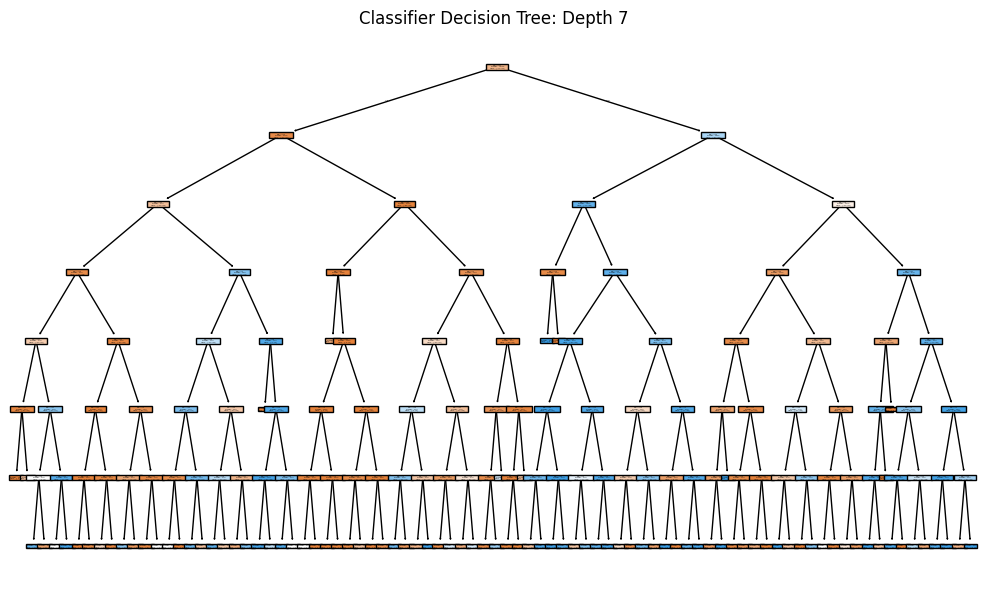

In [29]:
plt.figure(figsize=(10, 6))
plot_tree(best_dt_model, filled=True,
          feature_names=feature_names,
          precision=2, proportion=True)
plt.title(f"Classifier Decision Tree: Depth {best_dt_model.get_depth()}")
plt.tight_layout()
plt.show()

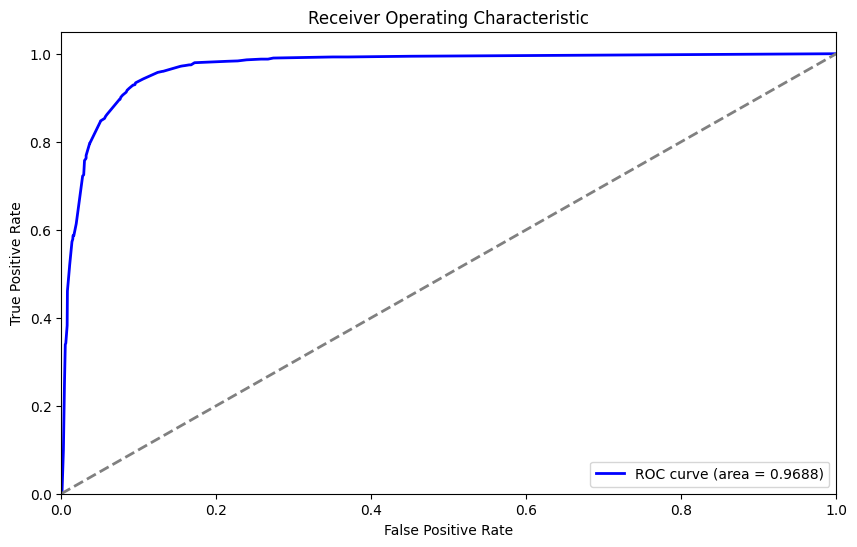

In [30]:
from sklearn.metrics import roc_curve, auc

# Plot ROC curve
y_scores = best_dt_model.predict_proba(X_test_optimal)[:, 1]
fpr, tpr, thresholds2 = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/var/folders/09/7fcnlqx173v03wyt8sxj1lzh0000gn/T/ipykernel_12786/2199355194.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)


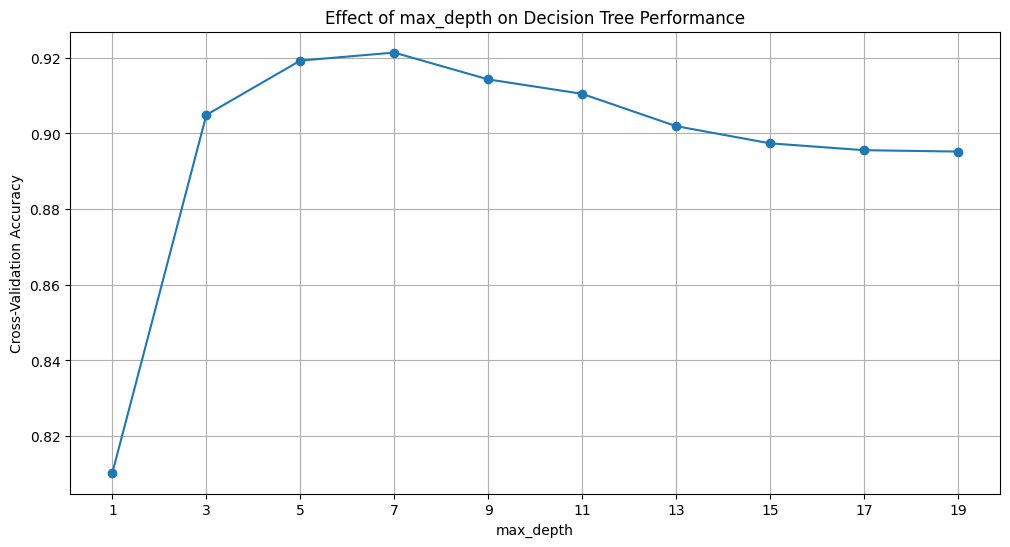

In [31]:
# Visualize hyperparameter tuning results
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(12, 6))

# Filter results for default min_samples values
default_samples = results[(results['param_min_samples_split'] == 2) &
                         (results['param_min_samples_leaf'] == 1)]

# Convert None to -1 for plotting purposes
default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)

# Sort by max_depth for proper x-axis order
default_samples = default_samples.sort_values('param_max_depth')

# Plot the results
plt.plot(default_samples['param_max_depth'],
         default_samples['mean_test_score'],
         marker='o', linestyle='-')

# Replace -1 with "None" in xticks
x_ticks = default_samples['param_max_depth'].unique()
x_labels = [str(int(x)) if x > 0 else "None" for x in x_ticks]
plt.xticks(x_ticks, x_labels)
plt.xlabel('max_depth')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Effect of max_depth on Decision Tree Performance')
plt.grid(True)
plt.show()